<img src = "https://www.santanderbank.com/us/documents/22507/2202391/DebitCardPage-Debit-Prmier-Cards_437x336.png/68eaaf59-35ec-44c7-82f8-2cf46a38d733?t=1554058009547" width="400"></img>

# Introduction
Santander always looking for ways to help their customers to understand financial health and identify which products and services might help them achieve their monetary goals.

Problem Statement:
is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?

Dataset contains numeric feature variables, the binary target column, and a string ID_code column.
The task is to predict the value of target column in the test set.

Data: 
1. train.csv - the training set.
2. test.csv - the test set.  
3. sample_submission.csv  

Data reference: (https://www.kaggle.com/c/santander-customer-transaction-prediction/data)

# <a id='0'>Content</a>

- <a href='#1'>1. Read the data</a>
- <a href='#2'>2. Data Understanding</a>
 - <a href='#5'>2.1 Missing values</a>
 - <a href='#6'>2.2 Statistics</a>
- <a href='#3'>3. Data Exploration</a>
 - <a href='#7'>3.1 Distribution of Train vs Test</a>
 - <a href='#8'>3.2 Distribution of Y variable</a>
 - <a href='#9'>3.3 Distribution of X variables</a>
 - <a href='#10'>3.4 Correlation</a>
 - <a href='#11'>3.5 Repeated values</a>
- <a href='#4'>4. Additional Features</a>
- <a href='#5'>5. Model</a>

In [1]:
# Input path

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv
/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv


In [2]:
# Import necessary libraries

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.model_selection import train_test_split

import lightgbm as lgb
import skopt

# <a id='1'>1. Read the data</a>

In [3]:
# Read the data

train = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/train.csv')
test  = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/test.csv')

In [4]:
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (200000, 202)
test shape: (200000, 201)


In [5]:
train.head(2)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.093,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.389,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518


In [6]:
test.head(2)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760


# <a id='2'>2. Data Understanding</a>

### <a id='5'>2.1 Missing values</a>

In [7]:
# Finding missing values in train and test data

def func(df):
    a = df.isnull().sum()
    b = df.count()
    c = (a/b) * 100
    d = pd.DataFrame(a, columns = ['Missingvalue%'])
    return d['Missingvalue%'].sum()

In [8]:
print('missing values in train data:', func(train))
print('missing values in test data:', func(test))

missing values in train data: 0
missing values in test data: 0


### Summary:
There is no missing value in train and test dataset

### <a id='6'>2.2 Statistics</a>

In [9]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [10]:
test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


### Summary: 
min, max, mean and std dev vaues seems to be similar for train and test data

# <a id='3'>3. Data Exploration</a>

### <a id='7'>3.1 Distribution of Train vs Test</a>

#### Let's try to plot Train[variables] vs Test[variables] for few features

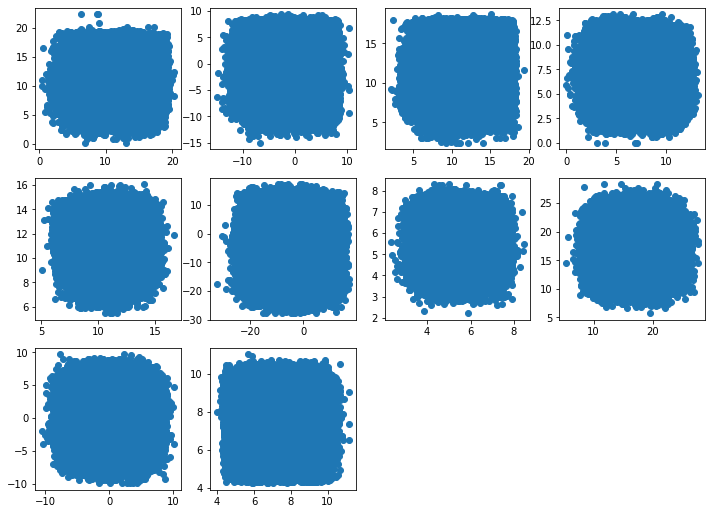

In [11]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'var_8', 'var_9',]  

i = 0
fig, ax = plt.subplots(figsize=(12,12))

for feature in features:    
    i = i + 1
    plt.subplot(4,4,i)     
    plt.scatter(train[feature], test[feature])

### <a id='8'>3.2 Distribution of Y variable</a>

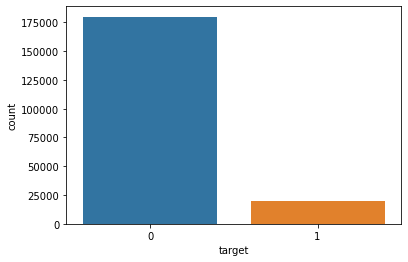

In [12]:
# Y distribution in train data

sns.countplot(train.target)

In [13]:
print('% of 1 in train data:', (train.target.value_counts()[1]/train.shape[0]) * 100)

% of 1 in train data: 10.049


### Summary: 
Data is highly imbalanced, only 10% of 1's in target(Y) column

### <a id='9'>3.3 Distribution of X variables</a>

In [14]:
# function to generate subplots for ('X' variables vs 'Y')

def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

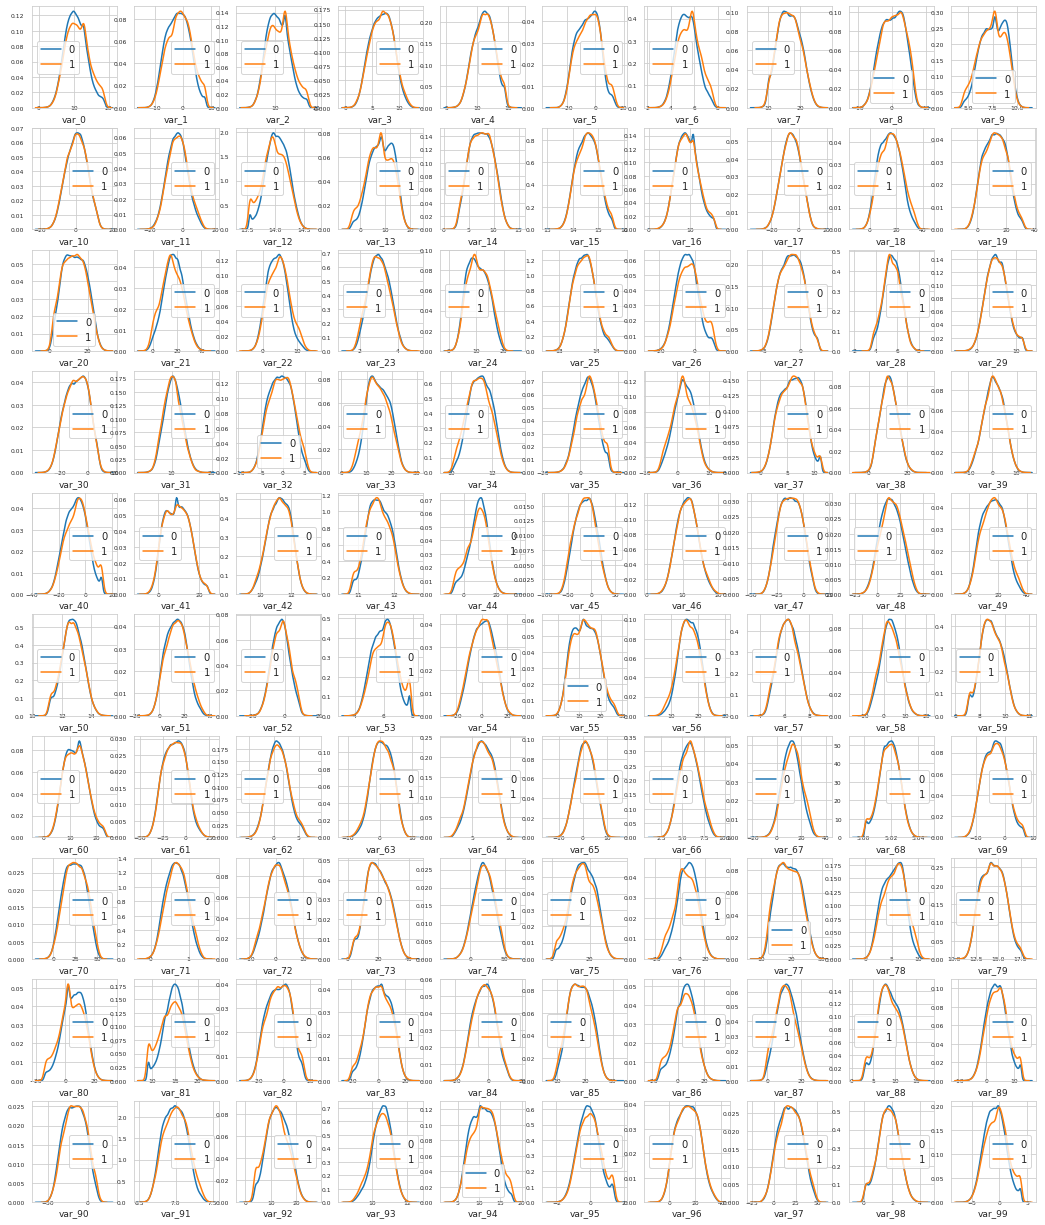

In [15]:
# Lets plot for few variables.

df1 = train.loc[train['target'] == 0]
df2 = train.loc[train['target'] == 1]
features = train.columns.values[2:102]
plot_feature_distribution(df1, df2, '0', '1', features)

### Summary: 
Most of the variables seems to be normally distributed.

### <a id='10'>3.4 Correlation</a>

#### Relationship between X variables

In [16]:
correlations = train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations.head()

,level_0,level_1,0
0,var_2,var_84,0.000002
1,var_84,var_2,0.000002
2,var_63,var_5,0.000002
3,var_5,var_63,0.000002
4,var_62,var_99,0.000003


### Summary:
It's clear that, relationship between X variables is very low.

### <a id='11'>3.5 Repeated values</a>

In [17]:
features = train.columns.values[2:202]

unique_max_train = []
for feature in features:
    values = train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])

In [18]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Count', 'Value'])).\
            sort_values(by = 'Count', ascending=False).head(10))

,68,108,126,12,91,103,148,71,161,25
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25
Count,1084,313,305,203,66,61,59,54,52,41
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723


# <a id='4'>4. Additional Features</a>

#### As we dont have much information on columns, lets try to create aggregated columns

In [19]:
idx = features = train.columns.values[2:202]
for df in [test, train]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['avg'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)     
    df['med'] = df[idx].median(axis=1)

# <a id='5'>5. Model</a>

### LightGBM (Leaf-Wise growth)

https://lightgbm.readthedocs.io/en/latest/Features.html


In [20]:
train.head(2)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_196,var_197,var_198,var_199,sum,min,max,avg,std,med
0,train_0,0,8.9255,-6.7863,11.9081,5.093,11.4607,-9.2834,5.1187,18.6266,...,7.8784,8.5635,12.7803,-1.0914,1456.3182,-21.4494,43.1127,7.281591,9.33154,6.77040
1,train_1,0,11.5006,-4.1473,13.8588,5.389,12.3622,7.0433,5.6208,16.5338,...,8.1267,8.7889,18.3560,1.9518,1415.3636,-47.3797,40.5632,7.076818,10.33613,7.22315


In [21]:
# X columns
features = [c for c in train.columns if c not in ['ID_code', 'target']]

# Y volumn
y = train['target']

### Some of the parameters of 'LightGBM'

In [22]:
params = {      'learning_rate': 0.01,
                'max_depth': -1,
                'num_leaves': 12,
                'feature_fraction': 0.1,
                'subsample': 0.2,
                'objective': 'binary',
                 'metric': 'auc',
                 'is_unbalance': True,
                 'bagging_freq': 5,
                 'boosting': 'gbdt' }                 

In [23]:
folds = StratifiedKFold(n_splits = 5, shuffle = False)

oof = np.zeros(len(train))
#predictions = np.zeros(len(test))

for fold_, (idxT, idxV) in enumerate(folds.split(train.values, y.values)):
    print("Fold {}".format(fold_))
    
    X_train = train.iloc[idxT][features]
    y_train = y.iloc[idxT] 
    X_val =   train.iloc[idxV][features] 
    y_val = y.iloc[idxV]
        
    train_data = lgb.Dataset(X_train, y_train)
    val_data   = lgb.Dataset(X_val, y_val)
    
    clf = lgb.train(params =  params ,                    
                    train_set = train_data, 
                    valid_sets = [train_data, val_data], 
                    num_boost_round = 20000,
                    verbose_eval = 1000, 
                    early_stopping_rounds = 5000)
    
    oof[idxV] = clf.predict(X_val, num_iteration=clf.best_iteration)
    
print("CV score: {:<8.5f}".format(roc_auc_score(y, oof)))   

Fold 0
Training until validation scores don't improve for 5000 rounds
[1000]	training's auc: 0.898921	valid_1's auc: 0.878378
[2000]	training's auc: 0.914444	valid_1's auc: 0.888266
[3000]	training's auc: 0.923563	valid_1's auc: 0.892739
[4000]	training's auc: 0.930494	valid_1's auc: 0.894475
[5000]	training's auc: 0.93646	valid_1's auc: 0.895529
[6000]	training's auc: 0.941865	valid_1's auc: 0.895622
[7000]	training's auc: 0.946791	valid_1's auc: 0.895545
[8000]	training's auc: 0.951537	valid_1's auc: 0.895636
[9000]	training's auc: 0.955957	valid_1's auc: 0.895414
[10000]	training's auc: 0.960057	valid_1's auc: 0.895139
[11000]	training's auc: 0.963836	valid_1's auc: 0.894909
[12000]	training's auc: 0.967297	valid_1's auc: 0.89463
Early stopping, best iteration is:
[7644]	training's auc: 0.949927	valid_1's auc: 0.895677
Fold 1
Training until validation scores don't improve for 5000 rounds
[1000]	training's auc: 0.899792	valid_1's auc: 0.876919
[2000]	training's auc: 0.915127	valid_1'

# Conclusion
 Validation accuracy is around 90% and can be further improved with below
 
 1) Tuning Hyperparameters
 
 2) Testing with other models
 
 3) Ensemble of different models